In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
import numba
from numba import jit

In [3]:
Lx, Ly = 1.0, 1.0
nx, ny = 41, 41

x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

dx = Lx / (nx - 1)
dy = Ly / (ny - 1)

Re = 10

dt = 1e-4

nt = 9000

In [4]:
u0 = numpy.zeros((ny, nx))
u0[-1, :] = 1
v0 = numpy.zeros((ny, nx))
p0 = numpy.zeros((ny, nx))

In [5]:
def l2_norm(p, p_ref):
    l2_diff = numpy.sqrt(numpy.sum((p - p_ref)**2))
    l2_ref = numpy.sqrt(numpy.sum(p_ref**2))
    if l2_ref > 1e-12:
        return l2_diff / l2_ref
    return l2_diff

In [6]:
def A(p):
        return (-4.0 * p[1:-1, 1:-1] +
                p[1:-1, :-2] + p[1:-1, 2:] +
                p[:-2, 1:-1] + p[2:, 1:-1]) / dx**2

In [22]:
def fractional_step(u0, v0, p0, dt, dx, Re, nt, rtol=1e-6):
    u = u0.copy()
    v = v0.copy()
    u_star = u.copy()
    v_star = v.copy()
    p = p0.copy()
    r = numpy.zeros_like(p)
    Ad = numpy.zeros_like(p)
    
    diff = rtol + 1
    for n in range(nt):
        u_star[1:-1, 1:-1] = ( u[1:-1, 1:-1] + 
                               dt * (- u[1:-1, 1:-1] * (u[1:-1, 2:] - u[1:-1, :-2]) / (2*dx)
                                     - v[1:-1, 1:-1] * (u[2:, 1:-1] - u[:-2, 1:-1]) / (2*dx)
                                     + (1/Re) * ( (u[1:-1, :-2] - 2 * u[1:-1, 1:-1] + u[1:-1, 2:]) / (dx**2) +
                                                  (u[:-2, 1:-1] - 2 * u[1:-1, 1:-1] + u[2:, 1:-1]) / (dx**2) )) )
        v_star[1:-1, 1:-1] = ( v[1:-1, 1:-1] + 
                               dt * (- u[1:-1, 1:-1] * (v[1:-1, 2:] - v[1:-1, :-2]) / (2*dx)
                                     - v[1:-1, 1:-1] * (v[2:, 1:-1] - v[:-2, 1:-1]) / (2*dx)
                                     + (1/Re) * ( (v[1:-1, :-2] - 2 * v[1:-1, 1:-1] + v[1:-1, 2:]) / dx**2 +
                                                  (v[:-2, 1:-1] - 2 * v[1:-1, 1:-1] + v[2:, 1:-1]) / (dx**2) )) )

        
        r[1:-1, 1:-1] = 1/dt * ( (u_star[1:-1, 2:] - u_star[1:-1, :-2]) / (2*dx) +
                                 (v_star[2:, 1:-1] - v_star[:-2, 1:-1]) / (2*dx) ) - A(p)
        
        d = r.copy()
        while diff > rtol:
            pk = p.copy()
            rk = r.copy()
            Ad[1:-1, 1:-1] = A(d)
            alpha = numpy.sum(r * r) / numpy.sum(d * Ad)
            p = pk + alpha * d
            r = rk - alpha * Ad
            beta = numpy.sum(r * r) / numpy.sum(rk * rk)
            d = r + beta * d
            diff = l2_norm(p, pk)
        
        
        
        
        
        u[1:-1, 1:-1] = u_star[1:-1, 1:-1] - (p[1:-1, 2:] - p[1:-1, :-2]) * dt / (2 * dx)
        v[1:-1, 1:-1] = v_star[1:-1, 1:-1] - (p[2:, 1:-1] - p[:-2, 1:-1]) * dt / (2 * dx)
        
        u[0, :] = 0
        v[0, :] = 0
        
#         p[0, :] = 0
        u[:, 0] = 0
        v[:, 0] = 0
        
#         p[:, 0] = 0
        u[:, -1] = 0
        v[:, -1] = 0
        
#         p[:, -1] = 0
        u[-1, :] = 1
        v[-1, :] = 0
        
        p[0, 2:] = p[0, :-2]
        p[2:, 0] = p[:-2, 0]
        p[2:, -1] = p[:-2, -1]
        p[-1, :] = 0
    
    
    return u, v, p

In [23]:
u, v, p = fractional_step(u0, v0, p0, dt, dx, Re, nt, rtol=1e-6)

In [30]:
p

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.84520710e-06, -5.80231818e-06, ...,
         5.80231818e-06,  2.84520710e-06,  0.00000000e+00],
       [ 0.00000000e+00, -5.95519741e-06, -1.17680958e-05, ...,
         1.17680958e-05,  5.95519741e-06,  0.00000000e+00],
       ...,
       [ 0.00000000e+00, -2.09376203e-01, -1.48707152e-01, ...,
         1.48707152e-01,  2.09376203e-01,  0.00000000e+00],
       [ 0.00000000e+00, -6.04688063e-01, -2.09376050e-01, ...,
         2.09376050e-01,  6.04688063e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

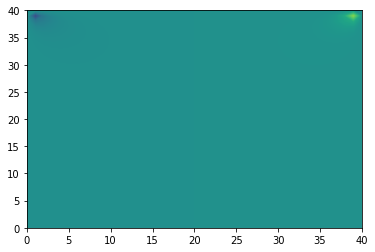

In [33]:
levels = numpy.linspace(-1.0, 1.0, num=501)
pyplot.contourf(p, levels=levels)